# 1. Dataset - NBA Players
#### **Alumnos**: Vinicius Gabriel Santos Dias

Descripción: el dataset NBA Players contiene estadísticas de jugadores de la NBA desde 1996 hasta 2022, incluyendo datos sobre su desempeño y características personales. https://www.kaggle.com/datasets/justinas/nba-players-data

Objetivo: el dataset no incluye una variable objetivo predefinida. Por ello, proponemos crear esta variable para predecir la capacidad de los jugadores de promediar 20 o más puntos por partido, basándonos en otras características de su desempeño y trayectoria en la NBA.

Comenzamos cargando el conjunto de datos.


### Descripción de las columnas del dataset

1. **Unnamed: 0**
   Índice numérico generado automáticamente.

2. **player_name**
   Nombre completo del jugador.

3. **team_abbreviation**
   Abreviatura del equipo en el que juega el jugador durante la temporada.

4. **age**
   Edad del jugador (en años) durante la temporada correspondiente.

5. **player_height**
   Altura del jugador en centímetros.

6. **player_weight**
   Peso del jugador en kilogramos.

7. **college**
   Universidad en la que estudió el jugador.

8. **country**
   País de origen del jugador.

9. **draft_year**
   Año en que el jugador fue seleccionado (draft) para la NBA.

10. **draft_round**
    Ronda en la que el jugador fue seleccionado en el draft.

11. **draft_number**
    Número exacto de selección del jugador en el draft.

12. **gp**
    Número de partidos jugados durante la temporada.

13. **pts**
    Puntos promedio anotados por partido.

14. **reb**
    Rebotes promedio obtenidos por partido.

15. **ast**
    Asistencias promedio realizadas por partido.

16. **net_rating**
    Diferencia promedio entre puntos anotados y permitidos por cada 100 posesiones.

17. **oreb_pct**
    Porcentaje de rebotes ofensivos del jugador.

18. **dreb_pct**
    Porcentaje de rebotes defensivos del jugador.

19. **usg_pct**
    Porcentaje de posesiones del equipo donde el jugador estuvo involucrado.

20. **ts_pct**
    Porcentaje de eficiencia de tiros, considerando tiros de campo, triples y tiros libres.

21. **ast_pct**
    Porcentaje de asistencias generadas por el jugador cuando está en el campo.

22. **season**
    Temporada correspondiente en formato "Año-Inicio" (ejemplo: 1996-97).

## 0 Importación y visualización inicial

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (KBinsDiscretizer, MinMaxScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler)
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
path = kagglehub.dataset_download("justinas/nba-players-data")
print("Path to dataset files:", path)

df = pd.read_csv(path + "/all_seasons.csv")
df.head()

# Crear la variable objetivo
threshold = 20
df['target'] = (df['pts'] >= threshold).astype(int)

Path to dataset files: /root/.cache/kagglehub/datasets/justinas/nba-players-data/versions/5


Se generó la variable objetivo target, que indica si un jugador tiene la posibilidad de promediar más de 20 puntos por partido.

In [ ]:
#Resumen de cada una de las variables del conjunto de datos.
print(df.shape)
df.info()

(12844, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12844 entries, 0 to 12843
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         12844 non-null  int64  
 1   player_name        12844 non-null  object 
 2   team_abbreviation  12844 non-null  object 
 3   age                12844 non-null  float64
 4   player_height      12844 non-null  float64
 5   player_weight      12844 non-null  float64
 6   college            10990 non-null  object 
 7   country            12844 non-null  object 
 8   draft_year         12844 non-null  object 
 9   draft_round        12844 non-null  object 
 10  draft_number       12844 non-null  object 
 11  gp                 12844 non-null  int64  
 12  pts                12844 non-null  float64
 13  reb                12844 non-null  float64
 14  ast                12844 non-null  float64
 15  net_rating         12844 non-null  float64
 16  oreb_pct  

El dataset consta de 12.844 instancias y 23 atributos. Se observa que las variables estan compuestas por distintos tipos de datos y que solo la variable college contiene valores nulos.

In [ ]:
# Removiendo las columnas 'Unnamed: 0', 'player_name', 'pts'
df = df.drop(['Unnamed: 0', 'player_name', 'pts'], axis=1)
df.head()

,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,gp,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,target
0,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,42,64,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,0
1,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,34,4,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97,0
2,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,12,41,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97,0
3,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,7,64,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97,0
4,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,22,52,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97,0


Removiendo las columnas Unnamed: 0 y Player Name porque son identificadores que no contribuyen al análisis.También eliminamos la columna Pts, ya que está directamente relacionada con la columna objetivo (target), lo que podría sesgar el modelo al proporcionar una ventaja no deseada.

In [ ]:
#Descripción numérica de las variables.
df.describe()

,age,player_height,player_weight,gp,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,target
count,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000
mean,27.045313,200.555097,100.263279,51.154158,3.558486,1.824681,-2.226339,0.054073,0.140646,0.184641,0.513138,0.131595,0.055979
std,4.339211,9.111090,12.426628,25.084904,2.477885,1.800840,12.665124,0.043335,0.062513,0.053545,0.101724,0.094172,0.229891
min,18.000000,160.020000,60.327736,1.000000,0.000000,0.000000,-250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,193.040000,90.718400,31.000000,1.800000,0.600000,-6.400000,0.021000,0.096000,0.149000,0.482000,0.066000,0.000000
50%,26.000000,200.660000,99.790240,57.000000,3.000000,1.200000,-1.300000,0.040000,0.130500,0.181000,0.525000,0.103000,0.000000
75%,30.000000,208.280000,108.862080,73.000000,4.700000,2.400000,3.200000,0.083000,0.179000,0.217000,0.563000,0.179000,0.000000
max,44.000000,231.140000,163.293120,85.000000,16.300000,11.700000,300.000000,1.000000,1.000000,1.000000,1.500000,1.000000,1.000000


## 1 Data Cleaning

### 1.1 Correcion de Tipo de Datos

Las columnas relacionadas con el draft tienen un problema: todas están clasificadas como tipo Object debido a la presencia del valor 'Undrafted' junto con los datos numéricos que indican el año del draft, la ronda y el número.

Para iniciar el proceso de limpieza corregiremos este problema.


In [ ]:
# Manejo de valores no numéricos en las columnas del draft y conversión a valores numéricos

# Convertir 'draft_year' a valores numéricos, forzar errores a NaN y reemplazar NaN por 0
df['draft_year'] = pd.to_numeric(df['draft_year'], errors='coerce').fillna(0).astype(int)

# Convertir 'draft_round' a valores numéricos, forzar errores a NaN y reemplazar NaN por 0
df['draft_round'] = pd.to_numeric(df['draft_round'], errors='coerce').fillna(0).astype(int)

# Convertir 'draft_number' a valores numéricos, forzar errores a NaN y reemplazar NaN por 0
df['draft_number'] = pd.to_numeric(df['draft_number'], errors='coerce').fillna(0).astype(int)

# Extrair o ano de início do campeonato da coluna 'season'
df['season'] = df['season'].str.split('-').str[0].astype(int)


# Mostrar los tipos de datos de todas las columnas después de la conversión
df.dtypes


,0
team_abbreviation,object
age,float64
player_height,float64
player_weight,float64
college,object
country,object
draft_year,int64
draft_round,int64
draft_number,int64
gp,int64


### 1.2 Tratamiento de Duplicados

In [ ]:
# Validamos si existen duplicados
dups = df.duplicated()

# Se muestran si hay  duplicados
print(dups.any())

#Numero de instancias duplicadas
df.duplicated().sum()

False


0

No hay valores duplicados

### 1.3 Columnas Categoricas

El dataset contiene columnas categóricas, que son:
- `team_abbreviation`
- `country`
- `College`

Dado que la columna `College` contiene valores nulos, abordaremos su codificación junto con su imputación.

#### 1.3.1 Columna Categorica - `country`

Dado que estamos hablando de la NBA, una liga en la que todos los equipos son de Estados Unidos y Canadá, es importante identificar si los jugadores son nacionales o extranjeros. Por ello, transformaremos esta columna en un formato binario.

In [ ]:
# Transformar la columna 'Country' en una variable binaria
# 1 indica que el jugador es de EE.UU. o Canadá, 0 en caso contrario
df['national_player?'] = df['country'].apply(lambda x: 1 if x in ['USA', 'Canada'] else 0)

# Eliminar la columna original 'country', ya que ha sido procesada
df = df.drop('country', axis=1)

# Verificar los resultados de la nueva columna creada
print(df[['national_player?']].head())

   national_player?
0                 1
1                 1
2                 1
3                 1
4                 1


#### 1.3.2 Columna Categorica - `team_abbreviation`

A veces, formar parte de un equipo tradicionalmente fuerte puede aumentar la probabilidad de que un jugador tenga un desempeño superior. Para capturar esta información en el conjunto de datos, crearemos una función donde el código del club se reemplaza por el porcentaje promedio de los jugadores que han pasado por él y han tenido un desempeño por encima del promedio.

In [ ]:
# Calcular el promedio de la columna 'target' para cada categoría en 'team_abbreviation'
# 'target' representa el desempeño promedio de los jugadores por equipo
team_target_mean = df.groupby('team_abbreviation')['target'].mean()

# Mapear los valores calculados de promedio al DataFrame original
# Sustituimos 'team_abbreviation' por el valor promedio correspondiente
df['team_encoded'] = df['team_abbreviation'].map(team_target_mean).fillna(0)

# Verificar los resultados de la nueva codificación
print(df[['team_abbreviation', 'team_encoded']].head())
df = df.drop('team_abbreviation', axis=1)


  team_abbreviation  team_encoded
0               HOU      0.057737
1               WAS      0.065611
2               VAN      0.055556
3               LAL      0.074592
4               DEN      0.042056


### 1.4 Imputación de Nulos

In [ ]:
df.isnull().sum()

,0
age,0
player_height,0
player_weight,0
college,1854
draft_year,0
draft_round,0
draft_number,0
gp,0
reb,0
ast,0


#### 1.4.1 Imputación de Nulos - Definir tipo Desconocido

En la columna 'College' solo hay valores nulos. Una breve suposición podría indicar que estas personas no asistieron a la universidad o estudiaron en instituciones fuera del circuito de draft. En este caso, trataremos los valores nulos como 'Desconocido'.

Sin embargo, una pregunta importante es: ¿Cuáles son las universidades con tradición en formar jugadores para la NBA?

Para abordar ambos problemas, crearemos una columna que clasifique las universidades según las siguientes distribuciones:
- 'Más de 300': 5,
- '200 a 300': 4,
- '100 a 200': 3,
- '50 a 100': 2,
- 'Menos de 50': 1,
- 'Desconocido': 0

In [ ]:
# Contar la cantidad de valores de cada college
college_counts = df['college'].value_counts()
print(college_counts)

college
Kentucky                           447
Duke                               410
North Carolina                     355
UCLA                               318
Arizona                            293
                                  ... 
Portland                             1
Augusta State                        1
Northwestern State                   1
Seward County Community College      1
Buffalo                              1
Name: count, Length: 356, dtype: int64


In [ ]:
# Contar la frecuencia de cada universidad (excluyendo 'Desconocido')
college_counts = df['college'][df['college'] != 'Desconocido'].value_counts()

# Tratar los valores nulos en la columna 'college' como 'Desconocido'
df['college'] = df['college'].fillna('Desconocido')

# Crear categorías basadas en el número de jugadores revelados
def categorize_college(college):
    if college == 'Desconocido':
        return 'Desconocido'
    count = college_counts.get(college, 0)  # Obtiene el número de jugadores por universidad
    if count > 300:
        return 'Más de 300'
    elif 200 < count <= 300:
        return '200 a 300'
    elif 100 < count <= 200:
        return '100 a 200'
    elif 50 < count <= 100:
        return '50 a 100'
    else:
        return 'Menos de 50'

df['college_category'] = df['college'].apply(categorize_college)

# Codificación ordinal de las categorías
ordinal_mapping = {
    'Más de 300': 5,
    '200 a 300': 4,
    '100 a 200': 3,
    '50 a 100': 2,
    'Menos de 50': 1,
    'Desconocido': 0
}
df['college_encoded'] = df['college_category'].map(ordinal_mapping)
df = df.drop(['college', 'college_category'], axis=1)

# Verificar el resultado
print(df['college_encoded'].value_counts())

college_encoded
3    3311
1    2672
2    2660
0    1854
5    1530
4     817
Name: count, dtype: int64


In [ ]:
df_test = df.select_dtypes(include=['number'])
# Separar las características y el objetivo
X = df_test.drop(columns=['target'])  # Excluir la columna objetivo
y = df_test['target']  # Usar la columna 'target' como variable objetivo

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Escaladores a probar
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

# Resultados
results = {}

# Configurar el número de vecinos para el KNN
n_neighbors = 5

# Crear y evaluar el pipeline para cada escalador
for scaler_name, scaler in scalers.items():
    pipeline = Pipeline([
        ('scaler', scaler),
        ('knn', KNeighborsClassifier(n_neighbors=n_neighbors))
    ])

    # Entrenar el modelo
    pipeline.fit(X_train, y_train)

    # Hacer predicciones en el conjunto de prueba
    y_pred = pipeline.predict(X_test)

    # Calcular la precisión
    accuracy = accuracy_score(y_test, y_pred)
    results[scaler_name] = accuracy

# Mostrar resultados
for scaler_name, accuracy in results.items():
    print(f"{scaler_name}: Accuracy = {accuracy:.4f}")


StandardScaler: Accuracy = 0.9741
MinMaxScaler: Accuracy = 0.9656
RobustScaler: Accuracy = 0.9745


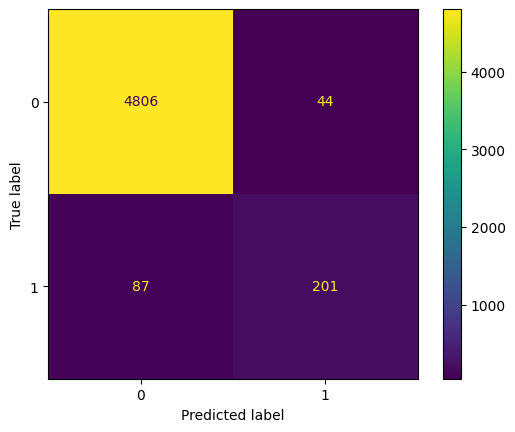

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.show()

#### 1.4.2 Imputación de Nulos - Imputación Estatistica -  Most Frequent

In [ ]:
# Seleccionar sólo columnas numéricas
df_test_moda = df.select_dtypes(include=['number'])

# Transformar los valores 0 en NaN
df_test_moda['college_encoded'] = df_test_moda['college_encoded'].replace(0, np.nan)

# Usar Imputer para reemplazar los valores NaN por la moda
imputer = SimpleImputer(strategy='most_frequent')
df_test_moda['college_encoded'] = imputer.fit_transform(df_test_moda[['college_encoded']])

# Verificar el resultado
print(df_test_moda['college_encoded'].value_counts())

college_encoded
3.0    5165
1.0    2672
2.0    2660
5.0    1530
4.0     817
Name: count, dtype: int64


In [ ]:
# Separar las características y el objetivo
X = df_test_moda.drop(columns=['target'])  # Excluir la columna objetivo
y = df_test_moda['target']  # Usar la columna 'target' como variable objetivo

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Resultados
results = {}

# Reutilizar X_train, X_test, y_train, y_test
for scaler_name, scaler in scalers.items():
    # Reutilizar el pipeline y definir nuevos parámetros
    pipeline.set_params(scaler=scaler, knn=KNeighborsClassifier(n_neighbors=n_neighbors))

    # Entrenar el modelo
    pipeline.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = pipeline.predict(X_test)

    # Calcular la precisión
    accuracy = accuracy_score(y_test, y_pred)
    results[scaler_name] = accuracy

# Mostrar resultados
for scaler_name, accuracy in results.items():
    print(f"{scaler_name}: Accuracy = {accuracy:.4f}")


StandardScaler: Accuracy = 0.9749
MinMaxScaler: Accuracy = 0.9661
RobustScaler: Accuracy = 0.9768


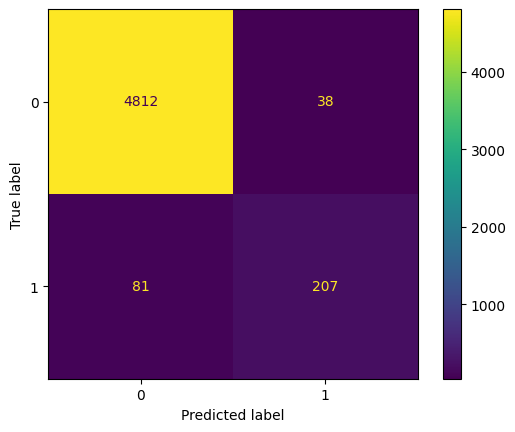

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.show()

#### 1.4.3 Imputación de Nulos - Interative Imputer - Random Forrest

In [ ]:
df_test_random = df.select_dtypes(include=['number'])

# Asegurar que los valores 0 sean reemplazados por np.nan
df_test_random['college_encoded'] = df_test_random['college_encoded'].replace(0, np.nan)

# Configurar el imputador con RandomForest
iterative_imputer = IterativeImputer(
    estimator=RandomForestRegressor(random_state=42),
    max_iter=30,
    random_state=42
)

# Aplicar el imputador directamente
df_test_random[['college_encoded']] = iterative_imputer.fit_transform(df_test_random[['college_encoded']])

# Agregar aleatoriedad y ajustar al rango de 1 a 5
df_test_random['college_encoded'] += np.random.uniform(-0.5, 0.5, size=len(df_test_random))
df_test_random['college_encoded'] = np.clip(np.round(df_test_random['college_encoded']), 1, 5).astype(int)

# Verificar solo la nueva distribución
print("Distribución después de la imputación (sin scaler):")
print(df_test_random['college_encoded'].value_counts())


Distribución después de la imputación (sin scaler):
college_encoded
3    4498
2    3327
1    2672
5    1530
4     817
Name: count, dtype: int64


In [ ]:
# Separar las características y el objetivo
X = df_test_random.drop(columns=['target'])  # Excluir la columna objetivo
y = df_test_random['target']  # Usar la columna 'target' como variable objetivo

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Resultados
results = {}

# Reutilizar X_train, X_test, y_train, y_test
for scaler_name, scaler in scalers.items():
    # Reutilizar el pipeline y definir nuevos parámetros
    pipeline.set_params(scaler=scaler, knn=KNeighborsClassifier(n_neighbors=n_neighbors))

    # Entrenar el modelo
    pipeline.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = pipeline.predict(X_test)

    # Calcular la precisión
    accuracy = accuracy_score(y_test, y_pred)
    results[scaler_name] = accuracy

# Mostrar resultados
for scaler_name, accuracy in results.items():
    print(f"{scaler_name}: Accuracy = {accuracy:.4f}")

StandardScaler: Accuracy = 0.9753
MinMaxScaler: Accuracy = 0.9648
RobustScaler: Accuracy = 0.9761


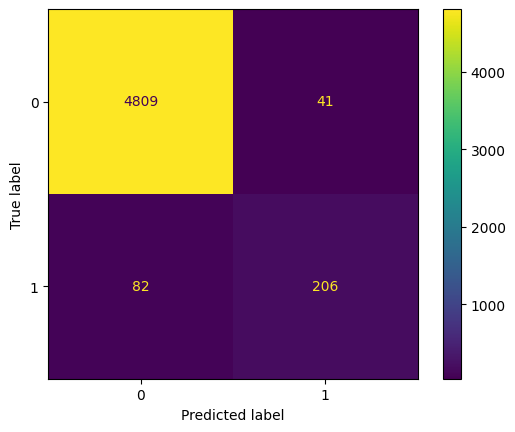

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.show()

#### 1.4.4 Imputación de Nulos - KNN Imputer

In [ ]:
# Crear un DataFrame solo con columnas numéricas
df_test = df.select_dtypes(include=['number'])

# Mostrar las primeras filas para verificar
df_test.head()
Counter(df_test['college_encoded'])

Counter({3: 3311, 1: 2672, 5: 1530, 0: 1854, 2: 2660, 4: 817})

In [ ]:
df_test = df.select_dtypes(include=['number'])

# Asegurar que los valores 0 sean reemplazados por np.nan
df_test['college_encoded'] = df_test['college_encoded'].replace(0, np.nan)

# Configurar el KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Aplicar el imputador directamente
df_test[['college_encoded']] = knn_imputer.fit_transform(df_test[['college_encoded']])

# Ajustar los valores al rango de 1 a 5
df_test['college_encoded'] += np.random.uniform(-0.5, 0.5, size=len(df_test))
df_test['college_encoded'] = np.clip(np.round(df_test['college_encoded']), 1, 5).astype(int)

# Verificar solo la nueva distribución
print("Distribución después de la imputación con KNN:")
print(df_test['college_encoded'].value_counts())

Distribución después de la imputación con KNN:
college_encoded
3    4475
2    3350
1    2672
5    1530
4     817
Name: count, dtype: int64


In [ ]:
# Separar las características y el objetivo
X = df_test.drop(columns=['target'])  # Excluir la columna objetivo
y = df_test['target']  # Usar la columna 'target' como variable objetivo

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Resultados
results = {}

# Reutilizar X_train, X_test, y_train, y_test
for scaler_name, scaler in scalers.items():
    # Reutilizar el pipeline y definir nuevos parámetros
    pipeline.set_params(scaler=scaler, knn=KNeighborsClassifier(n_neighbors=n_neighbors))

    # Entrenar el modelo
    pipeline.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred = pipeline.predict(X_test)

    # Calcular la precisión
    accuracy = accuracy_score(y_test, y_pred)
    results[scaler_name] = accuracy

# Mostrar resultados
for scaler_name, accuracy in results.items():
    print(f"{scaler_name}: Accuracy = {accuracy:.4f}")


StandardScaler: Accuracy = 0.9759
MinMaxScaler: Accuracy = 0.9659
RobustScaler: Accuracy = 0.9764


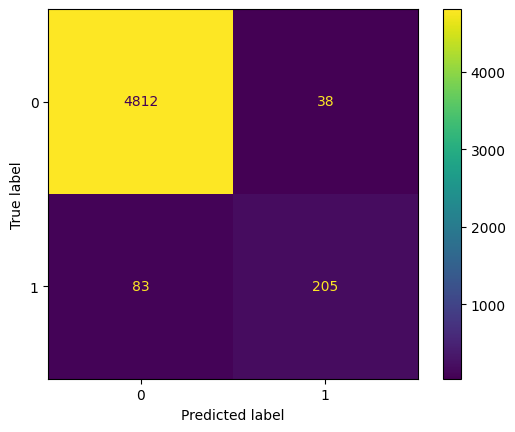

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
plt.show()

#### 1.4.4.1 Comparación de resultados

**Comparación de resultados**

**Tipo Desconocido**

- StandardScaler: Accuracy = 0.9741
- MinMaxScaler: Accuracy = 0.9656
- RobustScaler: Accuracy = 0.9745

**Imputación Estadística**

- StandardScaler: Accuracy = 0.9749
- MinMaxScaler: Accuracy = 0.9661
- RobustScaler: Accuracy = 0.9768

**Interactive Imputer - Random Forest**

- StandardScaler: Accuracy = 0.9753
- MinMaxScaler: Accuracy = 0.9654
- RobustScaler: Accuracy = 0.9761

**KNN Imputer**

- StandardScaler: Accuracy = 0.9745
- MinMaxScaler: Accuracy = 0.9652
- RobustScaler: Accuracy = 0.9755


El método más sólido es el **Interactive Imputer - Random Forest** y el metodo más solido de **Scaler** es **RobustScaler**



**Promedio de Accuracy por método de Scaler**

- **StandardScaler**: Promedio = 0.9747
- **MinMaxScaler**: Promedio = 0.9657
- **RobustScaler**: Promedio = 0.9759


***Promedio de los metodos de Imputación***

- **Tipo Desconocido**: Promedio = 0.9714
- **Imputación Estadística**: Promedio = 0.9726
- **Interactive Imputer - Random Forest**: Promedio = 0.9727
- **KNN Imputer**: Promedio = 0.9717

El método más sólido es el **Interactive Imputer - Random Forest** y el método más sólido de **Scaler** es el **RobustScaler**. Utilizaremos ambos para los próximos pasos.

In [ ]:
df = df_test_random

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))])

## 2 Evaluación de modelos

In [ ]:
# Definir los modelos y los hiperparámetros a probar
models_with_params = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__max_depth": [None, 10, 20]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=500, random_state=42),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__penalty": ["l2"]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5, 10]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "model__n_neighbors": [3, 5, 7],
            "model__weights": ["uniform", "distance"]
        }
    }
}

# Función para realizar Grid Search y evaluar los modelos
def grid_search_models(models_with_params, X_train, y_train, X_test, y_test):
    results = {}

    for model_name, config in models_with_params.items():
        # Crear el pipeline con el modelo y el escalador
        custom_pipeline = Pipeline([
            ('scaler', RobustScaler()),  # Escalador
            ('model', config["model"])  # Modelo actual
        ])

        # Configurar el GridSearchCV
        grid_search = GridSearchCV(
            estimator=custom_pipeline,
            param_grid=config["params"],
            cv=5,
            scoring="accuracy",
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Evaluar en el conjunto de prueba
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        # Almacenar los resultados
        results[model_name] = {
            "best_params": best_params,
            "accuracy": accuracy
        }

    return results

grid_results = grid_search_models(models_with_params, X_train, y_train, X_test, y_test)

for model_name, result in grid_results.items():
    print(f"{model_name}:")
    print(f"  Mejor configuración: {result['best_params']}")
    print(f"  Accuracy: {result['accuracy']:.4f}")

RandomForest:
  Mejor configuración: {'model__max_depth': 10, 'model__n_estimators': 200}
  Accuracy: 0.9823
LogisticRegression:
  Mejor configuración: {'model__C': 10, 'model__penalty': 'l2'}
  Accuracy: 0.9854
DecisionTree:
  Mejor configuración: {'model__max_depth': None, 'model__min_samples_split': 10}
  Accuracy: 0.9749
KNN:
  Mejor configuración: {'model__n_neighbors': 7, 'model__weights': 'distance'}
  Accuracy: 0.9788


A partir de ahora configuraremos el **Pipeline Final**, cuya función será probar y entrenar modelos con nuevas técnicas. Si estas nuevas técnicas obtienen resultados mejores que los encontrados anteriormente, el **Pipeline Final** será reemplazado por el pipeline aplicado.


In [ ]:
# Mejores hiperparametros
logistic_regression_model = LogisticRegression(C=10, penalty='l2', max_iter=500, random_state=42)
logistic_regression = LogisticRegression(C=10, penalty='l2', max_iter=500, random_state=42)

# Pipeline aystado
final_pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Escalador
    ('logistic_regression', logistic_regression_model)  # Modelo ganador
])

## 3 Column Transformer

In [ ]:
# Selecionando columnas numericas y categoricas para el column transform
columnas_numericas = [
    'age', 'player_height', 'player_weight', 'draft_year', 'draft_round',
    'draft_number', 'gp', 'reb', 'ast', 'net_rating', 'oreb_pct',
    'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season'
]

columnas_categoricas = ['national_player?', 'team_encoded', 'college_encoded']

# Definir ColumnTransformer, las columans numericas con robust scaler, las categoricas con one hot encoding
preprocessor = ColumnTransformer(transformers=[
    ('num', RobustScaler(), columnas_numericas),
    ('cat', OneHotEncoder(handle_unknown='ignore'), columnas_categoricas)
], remainder='passthrough')

# Pipeline final con ColumnTransformer
column_transformer_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', RobustScaler()),
    ('logistic_regression', logistic_regression_model)
])

column_transformer_pipeline.fit(X_train, y_train)

# Predicción y evaluación
y_pred = column_transformer_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo con ColumnTransformer: {accuracy:.4f}")

Precisión del modelo con ColumnTransformer: 0.9827


### 3.1 Discretización

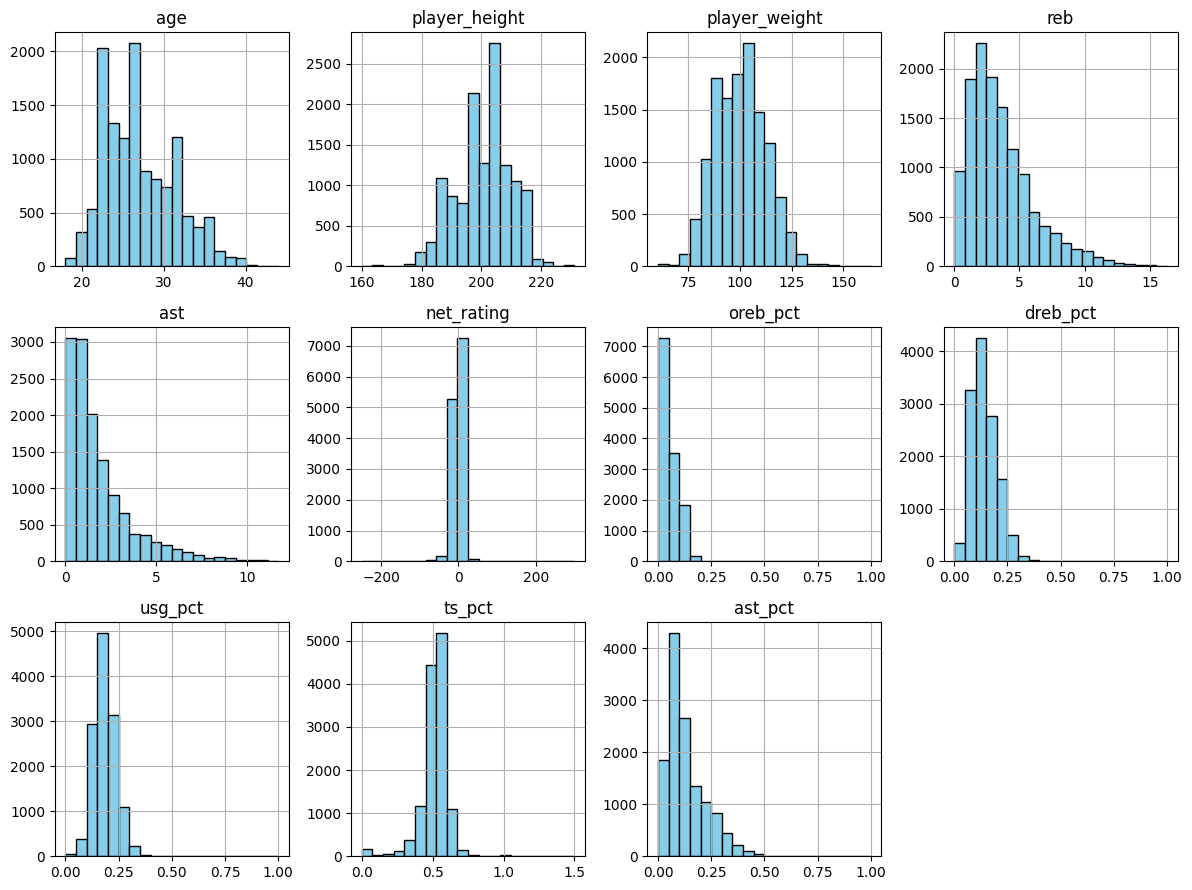

In [ ]:
# Selección de columnas para crear histogramas
df_hist = pd.DataFrame({
    'age': df_test['age'],
    'player_height': df_test['player_height'],
    'player_weight': df_test['player_weight'],
    'reb': df_test['reb'],
    'ast': df_test['ast'],
    'net_rating': df_test['net_rating'],
    'oreb_pct': df_test['oreb_pct'],
    'dreb_pct': df_test['dreb_pct'],
    'usg_pct': df_test['usg_pct'],
    'ts_pct': df_test['ts_pct'],
    'ast_pct': df_test['ast_pct']
})

# Crear histogramas
df_hist.hist(layout=(3, 4), figsize=(12, 9), bins=20, color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

In [ ]:
# Columnas a discretizar
columns_to_discretize = ['age', 'player_height', 'player_weight', 'reb', 'ast']

discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Preprocesador
preprocessor = ColumnTransformer([
    ('discretizer', discretizer, columns_to_discretize)
], remainder='passthrough')

pipeline_with_discretization = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', RobustScaler()),
    ('logistic_regression', logistic_regression_model)
])

pipeline_with_discretization.fit(X_train, y_train)
y_pred_discretized = pipeline_with_discretization.predict(X_test)
accuracy_discretized = accuracy_score(y_test, y_pred_discretized)

print(f"Modelo con discretización: {accuracy_discretized:.4f}")

Modelo con discretización: 0.9780


## 4 Selección de Caracteristicas

### 4.1 K-Best

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

results = []

# Probar diferentes números de características con SelectKBest
for k in range(X_train.shape[1], 0, -1):
    pipeline_with_selection = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_classif, k=k)),
        ('scaler', RobustScaler()),
        ('logistic_regression', LogisticRegression(C=10, penalty='l2', max_iter=500, random_state=42))
    ])

    # Entrenamiento
    pipeline_with_selection.fit(X_train, y_train)

    # Evaluación
    y_pred = pipeline_with_selection.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Guardar resultados
    results.append((k, accuracy))
    print(f"Número de características: {k}, Precisión: {accuracy:.4f}")

# Mejor número de características
best_k, best_accuracy = max(results, key=lambda x: x[1])
print(f"\nMejor número de características: {best_k} con precisión de {best_accuracy}")



Número de características: 19, Precisión: 0.9854
Número de características: 18, Precisión: 0.9858
Número de características: 17, Precisión: 0.9860
Número de características: 16, Precisión: 0.9860
Número de características: 15, Precisión: 0.9864
Número de características: 14, Precisión: 0.9862
Número de características: 13, Precisión: 0.9866
Número de características: 12, Precisión: 0.9809
Número de características: 11, Precisión: 0.9798
Número de características: 10, Precisión: 0.9794
Número de características: 9, Precisión: 0.9800
Número de características: 8, Precisión: 0.9811
Número de características: 7, Precisión: 0.9803
Número de características: 6, Precisión: 0.9786
Número de características: 5, Precisión: 0.9776
Número de características: 4, Precisión: 0.9761
Número de características: 3, Precisión: 0.9692
Número de características: 2, Precisión: 0.9619
Número de características: 1, Precisión: 0.9543

Mejor número de características: 13 con precisión de 0.9865706500583885


            Feature  Coefficient
3               reb     6.359424
8           usg_pct     4.351489
4               ast     1.604206
9            ts_pct     1.358088
2                gp     0.766729
11     team_encoded     0.341380
5        net_rating     0.285828
0        draft_year     0.076910
12  college_encoded     0.038022
1      draft_number    -0.098098
10          ast_pct    -2.249000
6          oreb_pct    -4.112670
7          dreb_pct    -5.475988


Text(0.5, 0, 'Coeficientes')

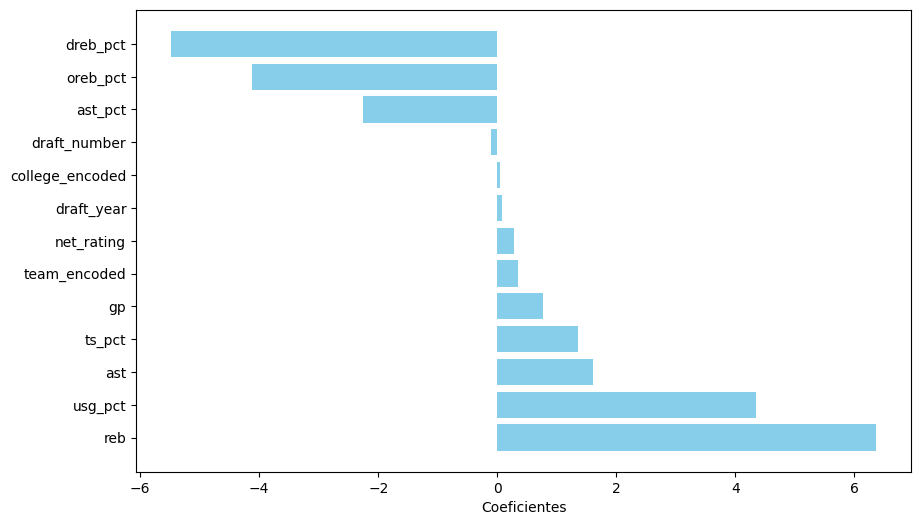

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Selección de características y modelo según k encontrado en la funcion anterior
k = 13
selector = SelectKBest(score_func=f_classif, k=k)

pipeline_with_selection = Pipeline([
    ('feature_selection', selector),
    ('scaler', RobustScaler()),
    ('logistic_regression', logistic_regression)
])

# Entrenamiento
pipeline_with_selection.fit(X_train, y_train)

# Obtener los coeficientes
selected_features_mask = selector.get_support()
selected_features = X_train.columns[selected_features_mask]
coefficients = logistic_regression.coef_.flatten()

# Crear DataFrame para mostrar resultados
coefficients_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
print(coefficients_df)

plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coeficientes')

### 4.2 RFE

In [ ]:
results = []

# Probar todas diferentes cantidades de características
for k in range(1, X_train.shape[1] + 1):
    rfe = RFE(estimator=logistic_regression, n_features_to_select=k)

    # Pipeline con RFE
    pipeline_with_rfe = Pipeline([
        ('scaler', RobustScaler()),     # Escalado
        ('feature_selection', rfe),     # Selección con RFE
        ('model', logistic_regression)  # Modelo
    ])

    pipeline_with_rfe.fit(X_train, y_train)

    y_pred = pipeline_with_rfe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results.append((k, accuracy))
    print(f"Número de características: {k}, Precisión: {accuracy:.4f}")


# Mejor número de características
best_k, best_accuracy = max(results, key=lambda x: x[1])
print(f"\nMejor número de características: {best_k} con precisión de {best_accuracy:.4f}")

# Ajustar el modelo con el mejor k
final_rfe = RFE(estimator=logistic_regression, n_features_to_select=best_k)
final_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', final_rfe),
    ('model', logistic_regression)
])

# Entrenar el pipeline final
final_pipeline.fit(X_train, y_train)

# Mostrar las características seleccionadas
selected_features_mask = final_rfe.support_
selected_features = X_train.columns[selected_features_mask]

print("\nCaracterísticas seleccionadas en el mejor modelo:")
print(selected_features)


Número de características: 1, Precisión: 0.9439
Número de características: 2, Precisión: 0.9436
Número de características: 3, Precisión: 0.9535
Número de características: 4, Precisión: 0.9815
Número de características: 5, Precisión: 0.9809
Número de características: 6, Precisión: 0.9831
Número de características: 7, Precisión: 0.9840
Número de características: 8, Precisión: 0.9866
Número de características: 9, Precisión: 0.9872
Número de características: 10, Precisión: 0.9864
Número de características: 11, Precisión: 0.9854
Número de características: 12, Precisión: 0.9856
Número de características: 13, Precisión: 0.9852
Número de características: 14, Precisión: 0.9854
Número de características: 15, Precisión: 0.9856
Número de características: 16, Precisión: 0.9860
Número de características: 17, Precisión: 0.9856
Número de características: 18, Precisión: 0.9858
Número de características: 19, Precisión: 0.9854

Mejor número de características: 9 con precisión de 0.9872

Características s

            Feature  Coefficient
1               reb     6.648197
5           usg_pct     4.123880
6            ts_pct     1.328158
2               ast     1.281073
0                gp     1.227051
8  national_player?     0.606756
7           ast_pct    -1.661546
3          oreb_pct    -4.288486
4          dreb_pct    -5.558880


Text(0.5, 0, 'Coeficientes')

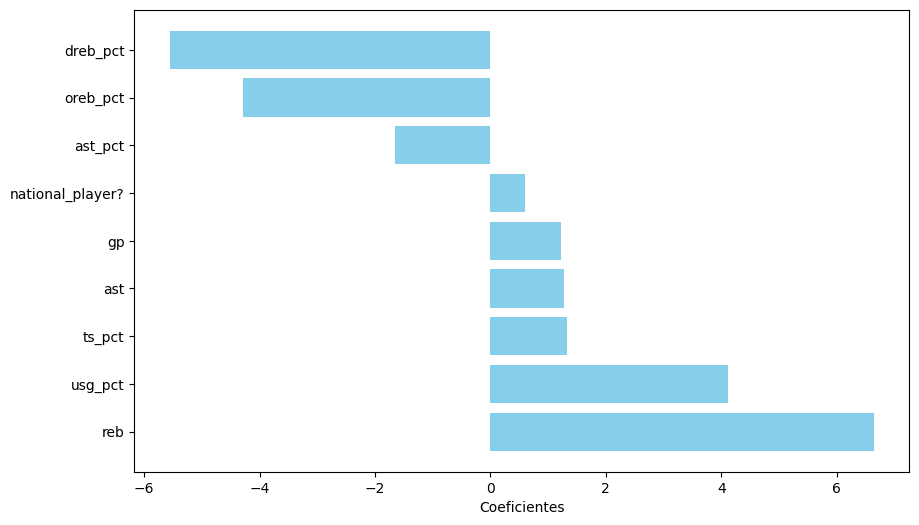

In [ ]:
# Configurando RFE con k = 9
k = 9
rfe = RFE(estimator=logistic_regression, n_features_to_select=k)

# Pipeline con RFE
pipeline_with_rfe = Pipeline([
    ('scaler', RobustScaler()),     # Escalado
    ('feature_selection', rfe),     # Selección de características con RFE
    ('model', logistic_regression)  # Modelo
])

# Entrenar el pipeline con k = 9
pipeline_with_rfe.fit(X_train, y_train)

# Obtener características seleccionadas y coeficientes
selected_features_mask = rfe.support_
selected_features = X_train.columns[selected_features_mask]
coefficients = logistic_regression.coef_.flatten()

# Crear DataFrame para mostrar coeficientes
coefficients_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
print(coefficients_df)


plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coeficientes')

### 4.3 ANOVA

In [ ]:
# Inicializar resultados
results = []

# Probar diferentes valores de k en SelectKBest
for k in range(1, X_train.shape[1] + 1):
    selector = SelectKBest(score_func=f_classif, k=k)

    # Pipeline con ANOVA
    pipeline_with_anova = Pipeline([
        ('feature_selection', selector),
        ('scaler', RobustScaler()),
        ('model', logistic_regression)
    ])

    # Entrenamiento y evaluación
    pipeline_with_anova.fit(X_train, y_train)
    y_pred = pipeline_with_anova.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Guardar resultados
    results.append((k, accuracy))
    print(f"Número de características: {k}, Precisión: {accuracy:.4f}")

# Mejor valor de k
best_k, best_accuracy = max(results, key=lambda x: x[1])
print(f"\nMejor número de características: {best_k} con precisión de {best_accuracy:.4f}")

# Ajustar modelo con el mejor k
final_selector = SelectKBest(score_func=f_classif, k=best_k)
final_pipeline = Pipeline([
    ('feature_selection', final_selector),
    ('scaler', RobustScaler()),
    ('model', logistic_regression)
])

# Entrenamiento final
final_pipeline.fit(X_train, y_train)

# Características seleccionadas y sus F-Scores
selected_features = X_train.columns[final_selector.get_support()]
scores = final_selector.scores_[final_selector.get_support()]

anova_results = pd.DataFrame({
    'Feature': selected_features,
    'F-Score': scores
}).sort_values(by='F-Score', ascending=False)

print("\nCaracterísticas seleccionadas:")
print(anova_results)

Número de características: 1, Precisión: 0.9543
Número de características: 2, Precisión: 0.9619
Número de características: 3, Precisión: 0.9692
Número de características: 4, Precisión: 0.9761
Número de características: 5, Precisión: 0.9776
Número de características: 6, Precisión: 0.9786
Número de características: 7, Precisión: 0.9803
Número de características: 8, Precisión: 0.9811
Número de características: 9, Precisión: 0.9800
Número de características: 10, Precisión: 0.9794
Número de características: 11, Precisión: 0.9798
Número de características: 12, Precisión: 0.9809
Número de características: 13, Precisión: 0.9866
Número de características: 14, Precisión: 0.9862
Número de características: 15, Precisión: 0.9864
Número de características: 16, Precisión: 0.9860
Número de características: 17, Precisión: 0.9860
Número de características: 18, Precisión: 0.9858
Número de características: 19, Precisión: 0.9854

Mejor número de características: 13 con precisión de 0.9866

Características 

### 4.4 Seleción Final de Caracteristicas

El modelo que logró la mejor selección de características fue el modelo **RFE** con **9 características**. Por lo tanto, será integrado en nuestro pipeline.

A partir de ahora, crearé la variable **best_accuracy** para rastrear la mejor precisión obtenida hasta el momento.


In [ ]:
final_rfe = RFE(estimator=logistic_regression, n_features_to_select=9)

final_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('feature_selection', final_rfe),
    ('model', logistic_regression)
])

final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy do modelo final: {accuracy:.4f}")
best_accuracy = accuracy

Accuracy do modelo final: 0.9872


In [ ]:
best_accuracy

0.9871545348384585

## 5 Power Transformer

### 5.1 Metodo Yeo-Johnson (Por defecto)

In [ ]:
# Pipeline actualizado con PowerTransformer
power_pipeline = Pipeline([
    ('power_transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler()),
    ('feature_selection', final_rfe),
    ('model', logistic_regression_model)
])

# Entrenamiento del pipeline
power_pipeline.fit(X_train, y_train)

# Predicción y evaluación
y_pred = power_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo con PowerTransformer: {accuracy:.4f}")

# Verificación y actualización del mejor pipeline
if accuracy > best_accuracy:
    best_accuracy = accuracy
    final_pipeline = power_pipeline
    print("✅ Mejor pipeline actualizado con PowerTransformer.")
else:
    print("⚠️ El pipeline no fue actualizado.")

Precisión del modelo con PowerTransformer: 0.9912
✅ Mejor pipeline actualizado con PowerTransformer.


### 5.2 Box-Cox

Aplicaremos el método Box-Cox aplicando previamente una transformación con MinMaxScaler, ya que el dataset contiene ceros y valores negativos.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Suponiendo que X_train, X_test, y_train, y_test ya están definidos

# Paso 1: Escalar los datos al rango (1, 2) para cumplir con los requisitos de Box-Cox
scaler = MinMaxScaler(feature_range=(1, 2))

# Paso 2: Aplicar Box-Cox Transformation
box_cox_transformer = PowerTransformer(method='box-cox')

# Paso 3: Construcción del pipeline con Box-Cox
power_pipeline = Pipeline([
    ('scaler', scaler),  # Escalado al rango requerido por Box-Cox
    ('box_cox_transform', box_cox_transformer),  # Transformación Box-Cox
    ('scaler_robust', RobustScaler()),  # Escalado adicional (opcional)
    ('feature_selection', final_rfe),  # Selección de características
    ('model', logistic_regression_model)  # Modelo final
])

# Entrenamiento del pipeline
power_pipeline.fit(X_train, y_train)

# Predicción y evaluación
y_pred = power_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo con Box-Cox: {accuracy:.4f}")

# Verificación y actualización del mejor pipeline
if accuracy > best_accuracy:
    best_accuracy = accuracy
    final_pipeline = power_pipeline
    print("✅ Mejor pipeline actualizado con Box-Cox.")
else:
    print("⚠️ El pipeline no fue actualizado.")


Precisión del modelo con Box-Cox: 0.9905
⚠️ El pipeline no fue actualizado.


In [ ]:
X_train

,age,player_height,player_weight,draft_year,draft_round,draft_number,gp,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,national_player?,team_encoded,college_encoded
5683,24.0,210.82,122.469840,2006,2,34,27,2.5,0.4,-5.6,0.092,0.147,0.174,0.474,0.067,2008,1,0.054299,3
7863,29.0,213.36,108.862080,2006,2,50,61,1.5,0.1,6.3,0.076,0.126,0.120,0.730,0.026,2013,1,0.054299,5
7489,22.0,208.28,113.398000,0,0,0,70,4.6,0.4,5.4,0.115,0.209,0.147,0.636,0.036,2012,1,0.057737,2
7582,30.0,205.74,102.058200,0,0,0,39,2.7,0.3,-10.0,0.143,0.203,0.145,0.392,0.051,2012,1,0.055944,2
6981,37.0,185.42,86.182480,0,0,0,24,1.4,1.4,-8.9,0.029,0.151,0.165,0.409,0.296,2011,1,0.058296,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6616,31.0,203.20,111.130040,0,0,0,30,11.5,1.3,-11.0,0.178,0.344,0.102,0.466,0.070,2010,1,0.058296,2
4876,27.0,195.58,97.522280,2003,2,43,59,1.6,1.0,2.6,0.021,0.095,0.151,0.546,0.094,2006,1,0.028037,5
12573,30.0,203.20,115.665960,2011,1,7,61,4.3,0.9,3.1,0.093,0.184,0.136,0.555,0.089,2022,0,0.053012,2
6021,25.0,205.74,116.119552,2007,2,41,18,3.3,0.4,-8.1,0.091,0.201,0.097,0.547,0.051,2009,1,0.056738,3


### 5.3 Seleción Power Transformer

In [ ]:
print(final_pipeline)

Pipeline(steps=[('power_transform', PowerTransformer()),
                ('scaler', RobustScaler()),
                ('feature_selection',
                 RFE(estimator=LogisticRegression(C=10, max_iter=500,
                                                  random_state=42),
                     n_features_to_select=9)),
                ('model',
                 LogisticRegression(C=10, max_iter=500, random_state=42))])


## 6 Numerical Transform

### 6.1 Uniform Quartile Transform

In [ ]:
quantile_pipeline = Pipeline([
    ('power_transform', PowerTransformer()),
    ('quantile_transform', QuantileTransformer(output_distribution='normal')),
    ('scaler', RobustScaler()),
    ('feature_selection', final_rfe),
    ('model', logistic_regression_model)
])

quantile_pipeline.fit(X_train, y_train)
y_pred = quantile_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia com QuantileTransformer: {accuracy:.4f}")

# Verificación y actualización del mejor pipeline
if accuracy > best_accuracy:
    best_accuracy = accuracy
    final_pipeline = power_pipeline
    print("✅ Mejor pipeline actualizado con PowerTransformer.")
else:
    print("⚠️ El pipeline no fue actualizado.")

Acurácia com QuantileTransformer: 0.9899
⚠️ El pipeline no fue actualizado.


### 6.2 Uniform Quartile Transformation

In [ ]:
# Aplicación
uniform_pipeline = Pipeline([
    ('power_transform', PowerTransformer()),
    ('quantile_transform', QuantileTransformer(output_distribution='uniform')),
    ('scaler', RobustScaler()),
    ('feature_selection', final_rfe),
    ('model', logistic_regression_model)
])

uniform_pipeline.fit(X_train, y_train)
y_pred = uniform_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia com QuantileTransformer: {accuracy:.4f}")

# Verificación y actualización del mejor pipeline
if accuracy > best_accuracy:
    best_accuracy = accuracy
    final_pipeline = power_pipeline
    print("✅ Mejor pipeline actualizado con PowerTransformer.")
else:
    print("⚠️ El pipeline no fue actualizado.")

Acurácia com QuantileTransformer: 0.9895
⚠️ El pipeline no fue actualizado.


## 7 Polinomial Features

In [ ]:
# Ajuste en el número de iteraciones sin cambiar hiperparámetros
logistic_regression_model.set_params(max_iter=2000)

# Pipeline con PolynomialFeatures integrado
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),  # Generación de características polinomiales
    ('power_transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler()),
    ('feature_selection', final_rfe),
    ('model', logistic_regression_model)
])

# Entrenamiento con supresión de advertencias de convergencia
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    poly_pipeline.fit(X_train, y_train)

# Predicción y evaluación
y_pred = poly_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión con PolynomialFeatures: {accuracy:.4f}")

# Verificación y actualización del mejor pipeline
if accuracy > best_accuracy:
    best_accuracy = accuracy
    final_pipeline = power_pipeline
    print("✅ Mejor pipeline actualizado con PowerTransformer.")
else:
    print("⚠️ El pipeline no fue actualizado.")

Precisión con PolynomialFeatures: 0.9903
⚠️ El pipeline no fue actualizado.


In [ ]:
# Ajuste en el número de iteraciones sin cambiar hiperparámetros
logistic_regression_model.set_params(max_iter=2000)

# Pipeline con PolynomialFeatures integrado
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=1, include_bias=True)),  # Generación de características polinomiales
    ('power_transform', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler()),
    ('feature_selection', final_rfe),
    ('model', logistic_regression_model)
])

# Entrenamiento con supresión de advertencias de convergencia
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    poly_pipeline.fit(X_train, y_train)

# Predicción y evaluación
y_pred = poly_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión con PolynomialFeatures: {accuracy:.4f}")

# Verificación y actualización del mejor pipeline
if accuracy > best_accuracy:
    best_accuracy = accuracy
    final_pipeline = power_pipeline
    print("✅ Mejor pipeline actualizado con PowerTransformer.")
else:
    print("⚠️ El pipeline no fue actualizado.")

Precisión con PolynomialFeatures: 0.9912
⚠️ El pipeline no fue actualizado.


## 8 Conclusión

In [ ]:
print("\033[1m El mejor pipeline encontrado a partir de aplicación de múltiples estrategias de preparación de datos fue:\033[0m")
print(final_pipeline)


 El mejor pipeline encontrado a partir de aplicación de múltiples estrategias de preparación de datos fue:
Pipeline(steps=[('power_transform', PowerTransformer()),
                ('scaler', RobustScaler()),
                ('feature_selection',
                 RFE(estimator=LogisticRegression(C=10, max_iter=500,
                                                  random_state=42),
                     n_features_to_select=9)),
                ('model',
                 LogisticRegression(C=10, max_iter=2000, random_state=42))])


In [ ]:
print("\033[1m La mejor accuracy encontrada a partir de aplicación de múltiples estrategias de preparación de datos fue:\033[0m")
print(f"{best_accuracy*100:.2f}%")

 La mejor accuracy encontrada a partir de aplicación de múltiples estrategias de preparación de datos fue:
99.12%


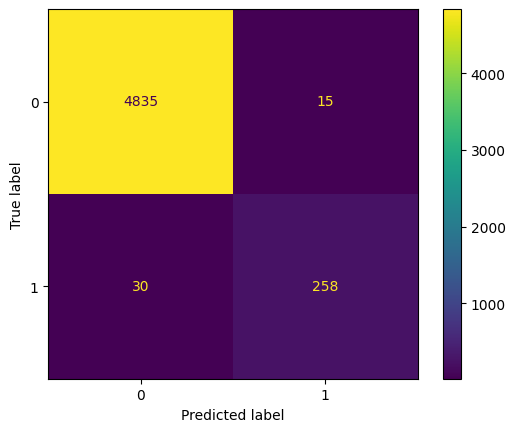

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot()
plt.show()


Al final, ajustando nuestro problema, la mejor precisión obtenida fue del **99.12%**, un valor considerablemente superior al **96.56%** obtenido al inicio. Esto generó una predicción mucho más robusta para identificar jugadores con un promedio de más de 20 puntos por partido, aplicado en este caso a un "entorno controlado" con datos únicamente de jugadores que ya han iniciado sus carreras y, en muchos casos, que ya las han finalizado.

Sin embargo, es muy probable que modelos como este se apliquen en los departamentos de scouting de equipos de la **NBA** y de otras ligas para identificar talentos, ya que es un modelo replicable si se logra una adecuada ingeniería de datos para extraer valores y patrones relevantes.

Consideramos que utilizar este dataset en la realización del trabajo fue bastante útil para poner en práctica nuestros nuevos conocimientos, además de resultar ser muy interesante.


# 2. Portafolio - Nuevas técnicas

En esta sección, probaremos diversas técnicas nuevas, ya sea para reducir los outliers o para realizar una ingeniería de características más detallada. Crearemos nuevas variables con el objetivo de aplicar distintas estrategias en un modelo ya bien entrenado para:

1. Ver hasta qué valor máximo de precisión podemos alcanzar.  
2. Ampliar el conjunto de estrategias y herramientas disponibles para futuros problemas de machine learning.

Para ello, presentaremos una breve introducción sobre cada método, explicando su funcionamiento y por qué puede ser útil. Luego, lo aplicaremos y analizaremos sus resultados.


## 1 - Eliminación de Multicolinealidad (VIF - Factor de Inflación de Varianza)


El VIF (Factor de Inflación de Varianza) mide la correlación de una variable con todas las demás del conjunto de datos. Valores altos indican redundancia, ya que la variable está altamente correlacionada con otras.

¿Por qué es interesante probarlo?  
- Reduce la redundancia entre variables.  
- Aumenta la estabilidad de modelos lineales.  
- Mejora la interpretabilidad del modelo al eliminar variables innecesarias.


In [ ]:
# Función para eliminar variables con alta multicolinealidad
def remove_multicollinearity(df, threshold=20.0):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    # Filtra las variables con VIF por debajo del umbral
    features_to_keep = vif_data[vif_data['VIF'] < threshold]['feature']

    print("VIF calculado para cada característica:\n", vif_data)
    print(f"\nCaracterísticas mantenidas (VIF < {threshold}):\n", features_to_keep.tolist())

    return df[features_to_keep]

# Aplicando la eliminación de multicolinealidad en el conjunto de entrenamiento
X_train_vif = remove_multicollinearity(X_train)

# Garantizando la misma selección en el conjunto de prueba
X_test_vif = X_test[X_train_vif.columns]


VIF calculado para cada característica:
              feature          VIF
0                age    43.313522
1      player_height  2011.571687
2      player_weight   230.186996
3         draft_year    16.308649
4        draft_round    28.323009
5       draft_number    11.553532
6                 gp     8.724238
7                reb     9.902465
8                ast     9.538827
9         net_rating     1.174526
10          oreb_pct     4.888542
11          dreb_pct    14.704518
12           usg_pct    16.776237
13            ts_pct    34.043268
14           ast_pct    12.578424
15            season  1568.483048
16  national_player?     7.240040
17      team_encoded    13.369507
18   college_encoded     6.135534

Características mantenidas (VIF < 20.0):
 ['draft_year', 'draft_number', 'gp', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ast_pct', 'national_player?', 'team_encoded', 'college_encoded']


In [ ]:
final_pipeline.fit(X_train_vif, y_train)

y_pred_vif = final_pipeline.predict(X_test_vif)

accuracy_vif = accuracy_score(y_test, y_pred_vif)
print(f"\nPrecisión sin multicolinealidad: {accuracy_vif:.4f}")

if accuracy_vif > best_accuracy:
    print("✅ Mejor precisión encontrada.")
else:
    print("⚠️ No fue la mejor precisión.")


Precisión sin multicolinealidad: 0.9866
⚠️ No fue la mejor precisión.


La precisión del modelo disminuyó en comparación con las versiones anteriores. Una posible explicación es que, para comprender las habilidades de un jugador de la NBA capaz de anotar más de 20 puntos por temporada, algunas variables pueden ser naturalmente redundantes.

En este contexto, la interacción entre atributos potencia el rendimiento y, por lo tanto, la redundancia entre variables no es perjudicial, sino relevante. Así, eliminar estas correlaciones pudo haber debilitado el modelo.


## 2 Winsorization

El VIF (Factor de Inflación de Varianza) mide la correlación de una variable con todas las demás del conjunto de datos. Valores altos indican redundancia, ya que la variable está altamente correlacionada con otras.

¿Por qué es interesante probarlo?  
- Reduce la redundancia entre variables.  
- Aumenta la estabilidad de modelos lineales.  
- Mejora la interpretabilidad del modelo al eliminar variables innecesarias.

In [ ]:
from scipy.stats.mstats import winsorize

# Función para aplicar Winsorization a todo el dataset
def apply_winsorization(df, limits=(0.01, 0.01)):
    df_winsorized = df.copy()
    for col in df_winsorized.columns:
        if df_winsorized[col].dtype != 'object':
            df_winsorized[col] = winsorize(df_winsorized[col], limits=limits)
    return df_winsorized

# Aplicando Winsorization en los conjuntos de entrenamiento y prueba
X_train_winsorized = apply_winsorization(X_train)
X_test_winsorized = apply_winsorization(X_test)

final_pipeline.fit(X_train_winsorized, y_train)

y_pred_winsorized = final_pipeline.predict(X_test_winsorized)

from sklearn.metrics import accuracy_score
accuracy_winsorized = accuracy_score(y_test, y_pred_winsorized)
print(f"Precisión después de Winsorization: {accuracy_winsorized:.4f}")

if accuracy_winsorized > best_accuracy:
    print("✅ Mejor precisión encontrada.")
else:
    print("⚠️ No fue la mejor precisión.")


Precisión después de Winsorization: 0.9909
⚠️ No fue la mejor precisión.


La Winsorización mostró resultados interesantes al reducir el impacto de los outliers. Sin embargo, como el objetivo principal de este estudio fue mejorar la precisión, el método no aportó mejoras en esta métrica.

A pesar de ello, reconozco que esta técnica tiene una gran aplicabilidad en futuros escenarios donde el control de valores extremos sea necesario.


## 3 FeatureAgglomeration

Agrupa variables similares en función de la distancia euclidiana, creando clústeres de características correlacionadas. Es una forma de reducción de dimensionalidad.

¿Por qué es interesante probarlo?

- Simplifica el modelo al reducir el número de variables.  
- Agrupa información correlacionada, manteniendo el contexto.



In [ ]:
from sklearn.cluster import FeatureAgglomeration

# Definir la agrupación de características
def feature_agglomeration(X_train, X_test, pipeline, k_range):
    best_accuracy_agglo = 0
    best_k = None

    for k in k_range:
        agglo = FeatureAgglomeration(n_clusters=k)
        # Aplicar la agrupación
        X_train_clustered = agglo.fit_transform(X_train)
        X_test_clustered = agglo.transform(X_test)

        # Ajustar el número de características para RFE
        n_features = X_train_clustered.shape[1]
        final_pipeline.named_steps['feature_selection'].set_params(n_features_to_select=min(9, n_features))

        final_pipeline.fit(X_train_clustered, y_train)

        y_pred_clustered = final_pipeline.predict(X_test_clustered)

        accuracy_clustered = accuracy_score(y_test, y_pred_clustered)
        print(f"Precisión después de Feature Agglomeration (k={k}): {accuracy_clustered:.4f}")

        if accuracy_clustered > best_accuracy_agglo:
            best_accuracy_agglo = accuracy_clustered
            best_k = k

    print(f"\nMejor k: {best_k} con precisión de {best_accuracy_agglo:.4f}")
    return best_k, best_accuracy_agglo

# Definir k_range antes de llamar la función
k_range = range(2, 18)

feature_agglomeration(X_train, X_test, final_pipeline, k_range)

if accuracy > best_accuracy:
    best_accuracy = accuracy
    print("✅ Mejor precisión encontrada.")
else:
    print("⚠️ No fue la mejor precisión.")

Precisión después de Feature Agglomeration (k=2): 0.9439
Precisión después de Feature Agglomeration (k=3): 0.9439
Precisión después de Feature Agglomeration (k=4): 0.9434
Precisión después de Feature Agglomeration (k=5): 0.9439
Precisión después de Feature Agglomeration (k=6): 0.9439
Precisión después de Feature Agglomeration (k=7): 0.9461
Precisión después de Feature Agglomeration (k=8): 0.9459
Precisión después de Feature Agglomeration (k=9): 0.9511
Precisión después de Feature Agglomeration (k=10): 0.9502
Precisión después de Feature Agglomeration (k=11): 0.9511
Precisión después de Feature Agglomeration (k=12): 0.9519
Precisión después de Feature Agglomeration (k=13): 0.9523
Precisión después de Feature Agglomeration (k=14): 0.9519
Precisión después de Feature Agglomeration (k=15): 0.9541
Precisión después de Feature Agglomeration (k=16): 0.9541
Precisión después de Feature Agglomeration (k=17): 0.9731

Mejor k: 17 con precisión de 0.9731
⚠️ No fue la mejor precisión.


La aglomeración de características no aportó beneficios al modelo, resultando en dificultades para interpretar las variables y una disminución en la precisión. Al agrupar atributos de los jugadores, se diluyeron informaciones importantes, lo que perjudicó el análisis.

Por lo tanto, esta técnica se mostró inadecuada para este problema.


## 4 Dynamic Feature Scaling (Z-Score Adaptativo)

Escala las variables de forma adaptativa usando el **Z-Score**, ajustando el impacto de variables con diferentes distribuciones.

¿Por qué es interesante probarlo?

- Normaliza variables de forma dinámica, haciendo el modelo más robusto.  
- Reduce el impacto de variables con grandes varianzas.  
- Mejora la convergencia de modelos lineales como el que estamos utilizando.


In [ ]:
# Escalado Dinámico de Características (Z-Score Adaptativo)
X_train_scaled = (X_train - X_train.mean()) / (X_train.std() + 1e-5)
X_test_scaled = (X_test - X_train.mean()) / (X_train.std() + 1e-5)

final_pipeline.fit(X_train_scaled, y_train)

y_pred_scaled = final_pipeline.predict(X_test_scaled)

accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
print(f"Precisión después del Escalado Dinámico de Características: {accuracy_scaled:.4f}")

if accuracy_scaled > best_accuracy:
    best_accuracy = accuracy_scaled
    final_pipeline = final_pipeline
    print("✅ Mejor precisión encontrada.")
else:
    print("⚠️ No fue la mejor precisión.")

Precisión después del Escalado Dinámico de Características: 0.9907
⚠️ No fue la mejor precisión.


La técnica fue interesante por aumentar la robustez del modelo, aunque causó una ligera disminución en la precisión. Al igual que la Winsorización, aunque aportó estabilidad al modelo, no contribuyó a mejorar la precisión.

Por ello, no se mantendrá en este proyecto, pero puede ser útil en otros contextos.


## 5 Feature Drift Detection


Detecta cambios en las distribuciones de las variables entre los conjuntos de entrenamiento y prueba. Se utilizó el KS-Test para identificar variables que no se comportan de la misma manera.

¿Por qué es interesante probarlo?

- Previene el *data leakage* al eliminar variables inestables.  
- Garantiza la generalización del modelo a nuevos datos.  
- Mejora la robustez al mantener solo variables consistentes.

In [ ]:
from scipy.stats import ks_2samp

# Verificando drift entre entrenamiento y prueba
for col in X_train.columns:
    stat, p_value = ks_2samp(X_train[col], X_test[col])
    if p_value < 0.05:
        print(f'⚠️ La característica {col} presenta drift (p={p_value:.4f})')

# Suponiendo que eliminamos las variables con drift
features_no_drift = [col for col in X_train.columns if ks_2samp(X_train[col], X_test[col])[1] >= 0.05]

X_train_drift_free = X_train[features_no_drift]
X_test_drift_free = X_test[features_no_drift]

final_pipeline.fit(X_train_drift_free, y_train)

y_pred_drift = final_pipeline.predict(X_test_drift_free)

accuracy_drift = accuracy_score(y_test, y_pred_drift)
print(f"Precisión después de eliminar características con drift: {accuracy_drift:.4f}")

if accuracy_drift > best_accuracy:
    best_accuracy = accuracy_drift
    print("✅ Mejor precisión encontrada.")
else:
    print("⚠️ No fue la mejor precisión.")

Precisión después de eliminar características con drift: 0.9912
⚠️ No fue la mejor precisión.


La aplicación de **Feature Drift Detection** resultó en una precisión equivalente al mejor resultado obtenido hasta ahora. Al eliminar variables inestables sin afectar el rendimiento, la técnica demostró ser eficaz para garantizar la robustez del modelo.

Su aplicación fue muy adecuada para este problema.


## 6 Creación de Variables Estadísticas


Creación de nuevas variables basadas en agregaciones estadísticas e interacciones entre variables existentes.  
Ejemplo: relación entre altura y peso, eficiencia en rebotes, experiencia del jugador, impacto ofensivo.

Estas nuevas variables serán evaluadas nuevamente mediante **RFE** para determinar la mejor cantidad de características, considerando la incorporación de nueva información al modelo.

¿Por qué es interesante probarlo?

- Incorpora contexto al modelo.  
- Revela patrones ocultos.  
- Genera nueva información que puede enriquecer el modelo.  
- Aumenta el poder predictivo sin alterar la estructura de los datos.


In [ ]:
df_test = df.copy()

# Interacciones avanzadas entre variables
df_test['height_weight_ratio'] = df_test['player_height'] / df_test['player_weight']
df_test['usg_ts_interaction'] = df_test['usg_pct'] * df_test['ts_pct']
df_test['ast_usg_ratio'] = df_test['ast'] / (df_test['usg_pct'] + 1e-5)

# Creación de variables estadísticas (GroupBy Aggregations)
df_test['avg_gp_season'] = df_test.groupby('season')['gp'].transform('mean')
df_test['net_rating_team_diff'] = df_test['net_rating'] - df_test.groupby('team_encoded')['net_rating'].transform('mean')
df_test['avg_reb_national'] = df_test.groupby('national_player?')['reb'].transform('mean')

# Variables derivadas basadas en eficiencia
df_test['total_reb_eff'] = df_test['oreb_pct'] + df_test['dreb_pct']
df_test['offensive_impact'] = (df_test['usg_pct'] * 0.4) + (df_test['ast_pct'] * 0.3) + (df_test['ts_pct'] * 0.3)
df_test['experience_rating'] = (df_test['season'] - df_test['draft_year']) * df_test['net_rating']

X = df_test.drop(columns=['target'])
y = df_test['target']

# División de los datos
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size=0.4, random_state=42)

### 6.1 RFE y Predicción

In [ ]:
results = []

# Regresión Logística para la selección de características
logistic_regression = LogisticRegression(C=10, max_iter=2000, random_state=42)

# Iteración sobre diferentes cantidades de características
for k in range(1, X_train_t.shape[1] + 1):
    # Pipeline con RFE
    nuevas_features_pipeline = Pipeline([
        ('power_transform', PowerTransformer()),  # Normalización
        ('scaler', RobustScaler()),              # Escalado robusto
        ('feature_selection', RFE(estimator=logistic_regression, n_features_to_select=k)),  # Selección de características
        ('model', LogisticRegression(C=10, max_iter=2000, random_state=42))  # Modelo final
    ])

    # Entrenamiento
    nuevas_features_pipeline.fit(X_train_t, y_train_t)

    # Evaluación
    y_pred = nuevas_features_pipeline.predict(X_test_t)
    accuracy = accuracy_score(y_test_t, y_pred)

    results.append((k, accuracy))
    print(f"Número de características: {k}, Precisión: {accuracy:.4f}")

# Mejor número de características
best_k, best_accuracy_new = max(results, key=lambda x: x[1])
print(f"\nMejor número de características: {best_k} con precisión de {best_accuracy_new:.4f}")

# Mostrar las características seleccionadas
selector = nuevas_features_pipeline.named_steps['feature_selection']
selected_features_mask = selector.support_
selected_features = X_train_t.columns[selected_features_mask]

print("\nCaracterísticas seleccionadas en el mejor modelo:")
print(selected_features)


Número de características: 1, Precisión: 0.9434
Número de características: 2, Precisión: 0.9558
Número de características: 3, Precisión: 0.9858
Número de características: 4, Precisión: 0.9868
Número de características: 5, Precisión: 0.9891
Número de características: 6, Precisión: 0.9893
Número de características: 7, Precisión: 0.9893
Número de características: 8, Precisión: 0.9883
Número de características: 9, Precisión: 0.9897
Número de características: 10, Precisión: 0.9895
Número de características: 11, Precisión: 0.9903
Número de características: 12, Precisión: 0.9901
Número de características: 13, Precisión: 0.9905
Número de características: 14, Precisión: 0.9907
Número de características: 15, Precisión: 0.9910
Número de características: 16, Precisión: 0.9918
Número de características: 17, Precisión: 0.9916
Número de características: 18, Precisión: 0.9910
Número de características: 19, Precisión: 0.9909
Número de características: 20, Precisión: 0.9912
Número de características: 21

In [ ]:
nuevas_features_pipeline = Pipeline([
    ('power_transform', PowerTransformer()),
    ('scaler', RobustScaler()),
    ('feature_selection', RFE(estimator=LogisticRegression(C=10, max_iter=2000, random_state=42), n_features_to_select=16)),
    ('model', LogisticRegression(C=10, max_iter=2000, random_state=42))
])

nuevas_features_pipeline.fit(X_train_t, y_train_t)

y_pred = nuevas_features_pipeline.predict(X_test_t)
accuracy = accuracy_score(y_test_t, y_pred)
print(f"Precisión del modelo final: {accuracy:.4f}")

if accuracy >= best_accuracy:
    best_accuracy = accuracy
    final_pipeline = nuevas_features_pipeline
    print("✅ Mejor precisión encontrada.")
else:
    print("⚠️ No fue la mejor precisión.")


Precisión del modelo final: 0.9918
✅ Mejor precisión encontrada.


La ingeniería de nuevas características estadísticas amplió el poder predictivo del modelo, siendo responsable del mejor resultado alcanzado hasta ahora.

La creación de variables derivadas fue interesante para capturar información más relevante y mejorar el rendimiento del modelo.


## 7 Detección de Deriva de Características + Creación de Variables Estadísticas

Combinación de técnicas de eliminación de variables con *drift* y creación de nuevas características estadísticas.

¿Por qué es interesante probarlo?

- Elimina variables inestables y, al mismo tiempo, enriquece el conjunto de datos con nueva información.  
- Maximiza la robustez y mantiene la relevancia de los datos.



In [ ]:
features_no_drift = [col for col in X_train.columns if ks_2samp(X_train[col], X_test[col])[1] >= 0.05]
X_train_drift_free = X_train[features_no_drift]
X_test_drift_free = X_test[features_no_drift]

print(f"Características mantenidas después de eliminar el drift: {features_no_drift}")

combined_pipeline = Pipeline([
    ('power_transform', PowerTransformer()),
    ('scaler', RobustScaler()),
    ('feature_selection', RFE(
        estimator=LogisticRegression(C=10, max_iter=2000, random_state=42),
        n_features_to_select=min(16, len(features_no_drift))
    )),
    ('model', LogisticRegression(C=10, max_iter=2000, random_state=42))
])

combined_pipeline.fit(X_train_drift_free, y_train)

y_pred_combined = combined_pipeline.predict(X_test_drift_free)
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f"\nPrecisión después de combinar Feature Drift + Pipeline avanzado: {accuracy_combined:.4f}")

if accuracy_combined > best_accuracy:
    best_accuracy = accuracy_combined
    final_pipeline = combined_pipeline
    print("✅ Mejor precisión encontrada.")
else:
    print("⚠️ No fue la mejor precisión.")


Características mantenidas después de eliminar el drift: ['age', 'player_height', 'player_weight', 'draft_year', 'draft_round', 'draft_number', 'gp', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season', 'national_player?', 'team_encoded', 'college_encoded']

Precisión después de combinar Feature Drift + Pipeline avanzado: 0.9909
⚠️ No fue la mejor precisión.


La combinación de estas técnicas resultó en un **trade-off**: hubo una reducción en la precisión en comparación con el uso aislado de las variables estadísticas, pero con una mejora en la robustez.

Aunque aumentó la estabilidad del modelo, esta combinación no cumplió con el objetivo principal de mejorar la precisión. Por ello, será descartada en este proyecto, aunque podría explorarse en otros contextos.

Cabe destacar que la predicción realizada con estas técnicas por separado generó mejores resultados, por lo que, en este caso, sería más adecuado optar por una de las dos técnicas anteriores en lugar de combinarlas.


## 8 Conclusión

In [ ]:
print(best_accuracy)

0.9918256130790191


In [ ]:
print(final_pipeline)

Pipeline(steps=[('power_transform', PowerTransformer()),
                ('scaler', RobustScaler()),
                ('feature_selection',
                 RFE(estimator=LogisticRegression(C=10, max_iter=2000,
                                                  random_state=42),
                     n_features_to_select=16)),
                ('model',
                 LogisticRegression(C=10, max_iter=2000, random_state=42))])


Para concluir, probar diversas técnicas nuevas fue muy interesante para ampliar los conocimientos en la disciplina. Es importante destacar que, a diferencia de los últimos temas de la Actividad 2, aquí no nos enfocamos tanto en modificar el pipeline con las técnicas, sino en realizar cambios directamente en los datos de entrenamiento y observar cómo impactaban en las predicciones. Esto fue útil para mejorar las habilidades de manipulación de datos.

Por último, me gustaría decir que, personalmente, fue divertido aplicar estas técnicas. Aunque no entiendo mucho sobre baloncesto, fue interesante analizar las métricas que, poco a poco, demostraban ser importantes para comprender la capacidad de los jugadores de lograr un promedio de 20 puntos por partido.
